## Community Detection 

using modularity maximization algorithms 
- Clauset-Newman-Moore (CNM)
- Louvain
- Leiden
- Paris
- Using Eigenvector

on synthetic generated network using `Lancichinetti-Fortunato-Radicchi (LFR)` benchmarks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [44]:
from cdlib import algorithms , evaluation
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

In [81]:
from sklearn.metrics import normalized_mutual_info_score


In [42]:
def draw_graph_com(G,coms,colors=None,fig_size=(8,8)):
    
    color_map = {} # map vertex to community to be used as color map
    for i,com in enumerate(coms):
        for v in com:
            color_map[v] = i 
    plt.figure(figsize=fig_size)
    nx.draw(G,cmap=plt.get_cmap('viridis'),node_color=[color_map[v] for v in G.nodes],with_labels=True)
    plt.show()

## Explore various CD algorithms on toy example

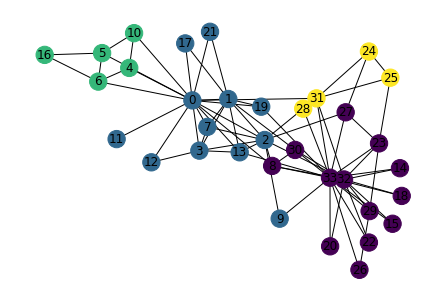

In [7]:
G = nx.karate_club_graph()
coms = algorithms.louvain(G,weight='weight',resolution=1.,randomize=False)

draw_graph_com(G,coms.communities)

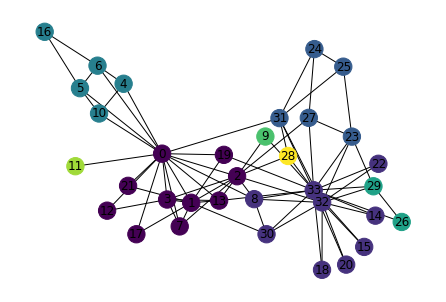

In [9]:
G = nx.karate_club_graph()
coms = algorithms.surprise_communities(G)

draw_graph_com(G,coms.communities)

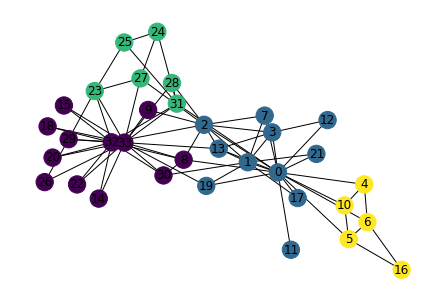

In [10]:
G = nx.karate_club_graph()
coms = algorithms.leiden(G)

draw_graph_com(G,coms.communities)

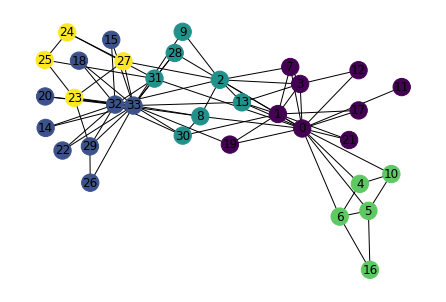

In [11]:
G = nx.karate_club_graph()
coms = algorithms.walktrap(G)

draw_graph_com(G,coms.communities)

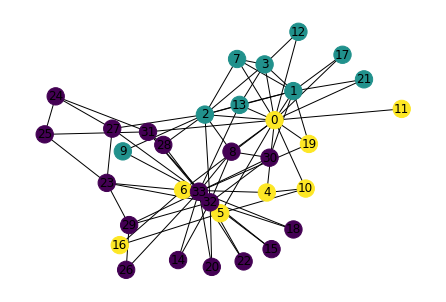

In [12]:
#Clauset-Newman-Moore
G = nx.karate_club_graph()
coms = algorithms.greedy_modularity(G)

draw_graph_com(G,coms.communities)

## LFR benchmark

In [15]:
from networkx.generators.community import LFR_benchmark_graph as lfr

In [90]:
from cdlib.benchmark import LFR
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
G, coms = LFR(n, tau1, tau2, mu, average_degree=5, min_community=20)

In [17]:
# parameters
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
G = lfr(
    n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
)

In [112]:
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
G = lfr(
    n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
)

In [ ]:
draw_graph_com(G,)

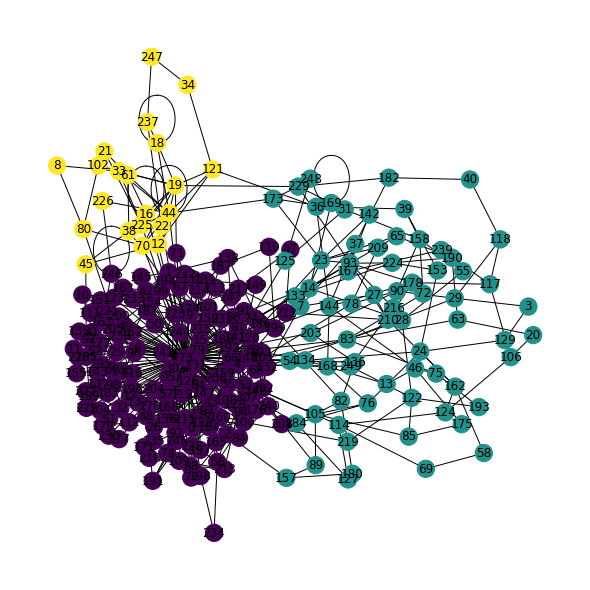

In [113]:
draw_graph_com(G,to_community_list(G))

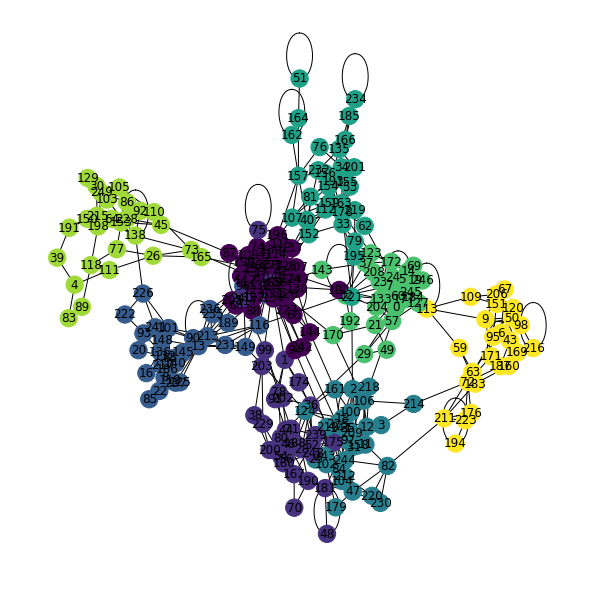

In [92]:
coms = algorithms.leiden(G)

draw_graph_com(G,coms.communities)

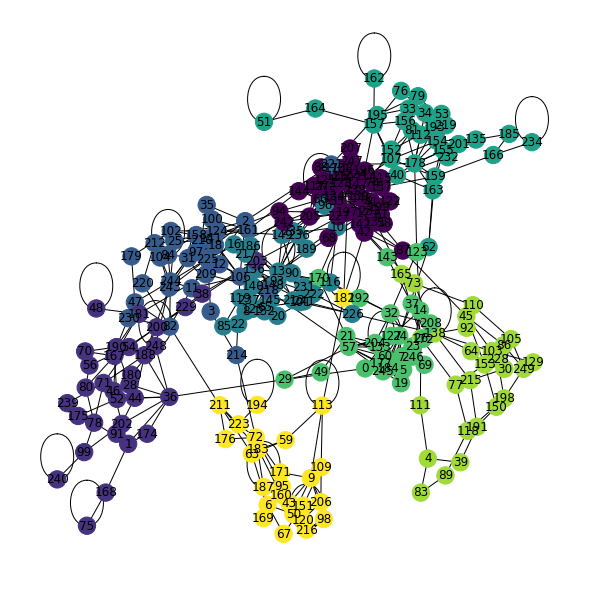

In [93]:
coms = algorithms.louvain(G,weight='weight',resolution=1.,randomize=False)

draw_graph_com(G,coms.communities)

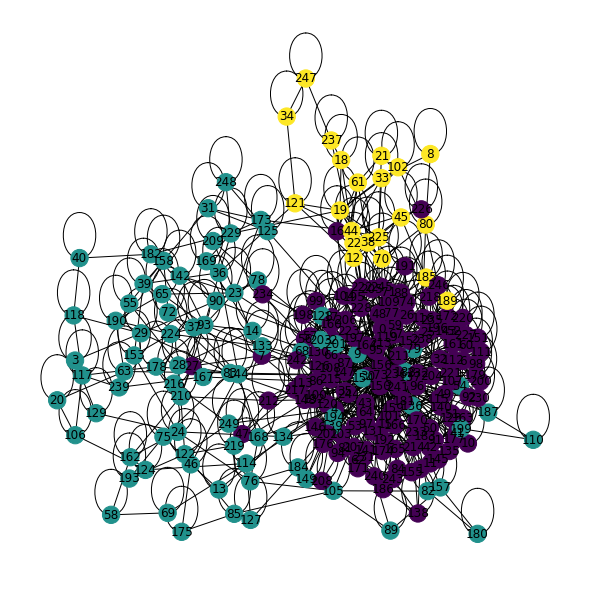

In [115]:
coms = algorithms.paris(G)

draw_graph_com(G,coms.communities)

In [36]:
def to_community_list(G):
    #Assumption: communities are disjoint
    l=[]
    visited=set()
    for v in G:
        if v not in visited:
            temp = [node for node in G.nodes[v]["community"]]
            l.append(temp)
            for t in temp:
                visited.add(t)
    return l      

In [67]:
def to_vertex_community(coms):
    return [
        x[1]
        for x in sorted(
            [
                (node, nid)
                for nid, cluster in enumerate(coms)
                for node in cluster
            ],
            key=lambda x: x[0],
        )
    ]

In [45]:
y_true = to_community_list(G)

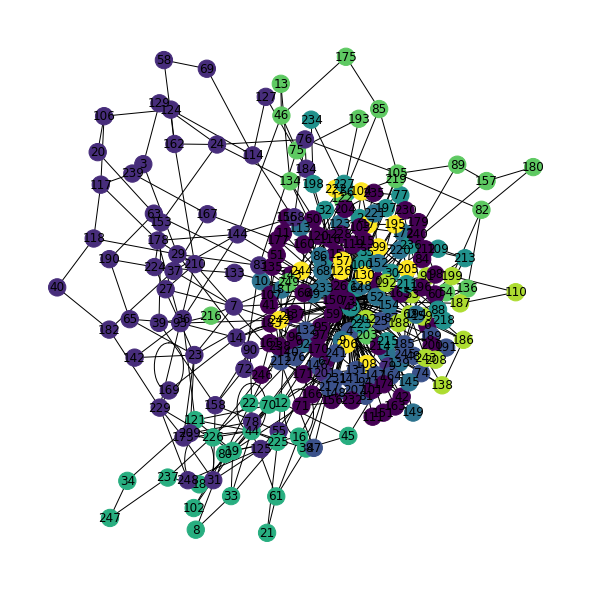

In [48]:
coms = algorithms.louvain(G,weight='weight',resolution=1.,randomize=False)

draw_graph_com(G,coms.communities)

In [52]:
from sklearn.metrics import normalized_mutual_info_score

In [80]:
def normalized_mutual_info_acc(coms_pred, coms_true):
    return normalized_mutual_info_score(
        to_vertex_community(coms_true), to_vertex_community(coms_pred)
    )


## Exp1:
    generate LFR using uniform distribution in parameters
    

In [1]:
import numpy as np
from CD_util import *

In [98]:
import time

In [146]:
def generate_graph(n_low=250,n_high=10000):
    n = np.random.randint(n_low,n_high)
    tau1 = 3
    tau2 = 1.5
    mu = np.random.uniform(0.03,0.75)
    max_degree = int(0.1*n)
    max_community = int(0.1*n)
    average_degree = 20
    G = lfr(
        n, tau1, tau2, mu, average_degree=average_degree, max_community=max_community,max_degree=max_degree, seed=10,
    )
    return G 

In [279]:
# n in [10,200], tau in [2,5], tau2 in [1.1,2], mu in [0.05,0.3]
num_trails = 10
metric = []
params = []
graphs = []

sizes = [250, 500, 600, 700, 800, 900, 1000, 1200, 2000, 2500, 2800, 3000,5000,8000,10000]
for j in range(1,len(sizes)):
    metric_sub = []
    params_sub = []
    graphs_sub = []
    for i in range(num_trails):

        try:
            now=time.time()
            G = generate_graph(sizes[j-1],sizes[j])
            graph_gen_time = time.time()-now
            print("graph generated")

        #construct graph

            params_sub.append(len(G.degree))
            graphs_sub.append(G)
            #experiment


            com_true = to_community_list(G)

            now=time.time()
            coms_louvain = algorithms.louvain(G,weight='weight',resolution=1.,randomize=False)
            coms_louvain_delay = time.time()-now

            now=time.time()
            coms_leiden = algorithms.leiden(G)
            coms_leiden_delay = time.time()-now

            now=time.time()
            coms_CNM = algorithms.greedy_modularity(G)
            coms_CNM_delay = time.time()-now

            now=time.time()
            coms_eig = algorithms.eigenvector(G)
            coms_eig_delay=time.time()-now

            now=time.time()
            coms_paris = algorithms.paris(G)
            coms_paris_delay=time.time()-now

            com_algs = {'louvain':(coms_louvain,coms_louvain_delay),'leiden':(coms_leiden,coms_leiden_delay), 
                        'CNM' : (coms_CNM , coms_CNM_delay),'eig':(coms_eig,coms_eig_delay),'paris':(coms_paris,coms_paris_delay)}
            result = {}
            for ca in com_algs:
                result[ca] = (normalized_mutual_info_acc(com_algs[ca][0].communities,com_true),com_algs[ca][1])

            metric_sub.append(result)
            
        except:
            print("error")
            continue
        
    metric.append(metric_sub)
    params.append(params_sub)
    graphs.append(graphs_sub)

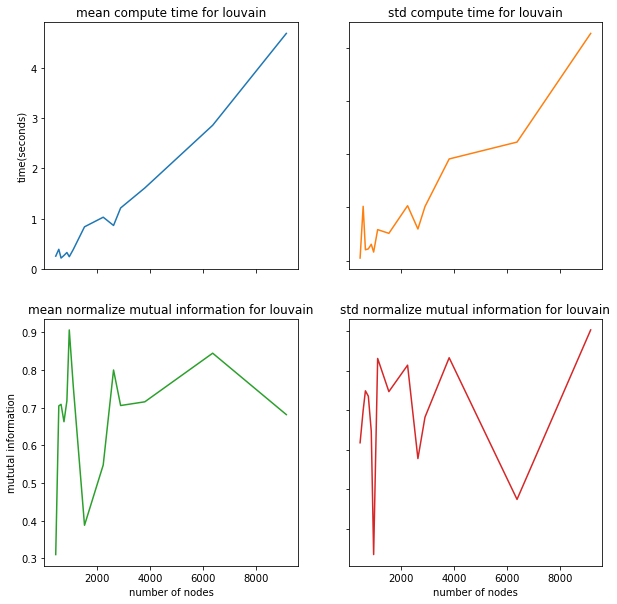

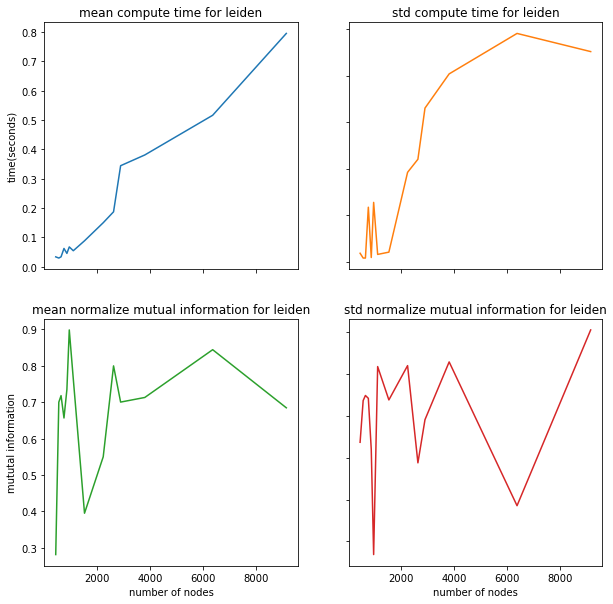

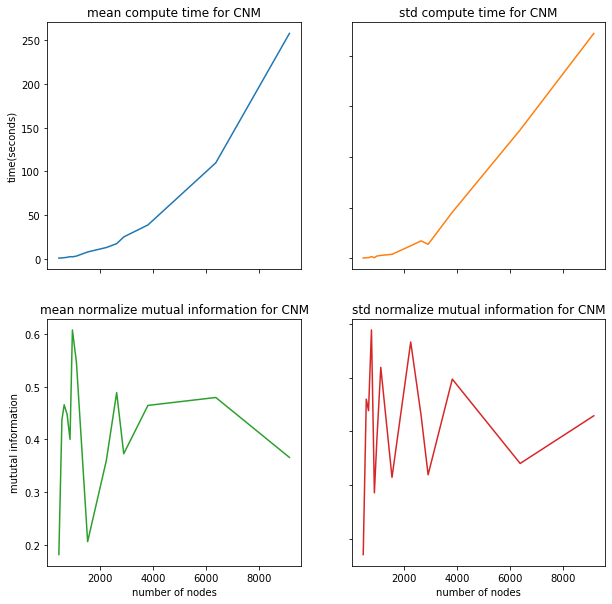

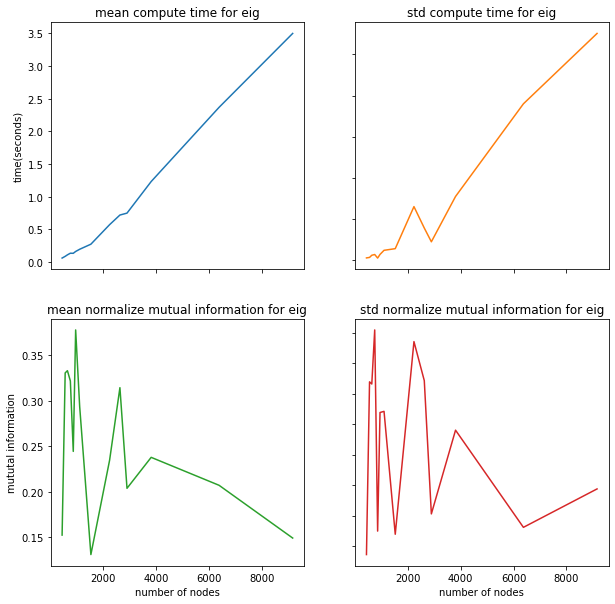

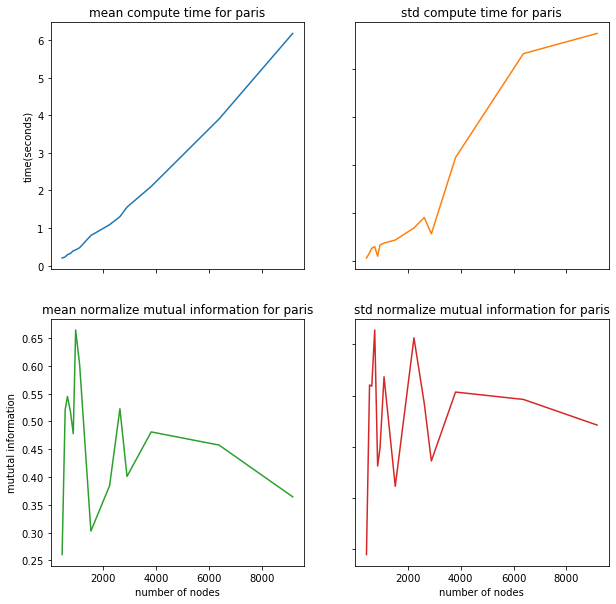

In [190]:

for ca in com_algs:
    running_time_mean = []
    running_time_std = []
    nmi_mean = []
    nmi_std = []
    degree =[]
    for i,me in enumerate(metric):
        
        running_time_mean.append(np.mean([m[ca][1] for m in me]))
        running_time_std.append(np.std([m[ca][1] for m in me]))

        nmi_mean.append(np.mean([m[ca][0] for m in me]))
        nmi_std.append(np.std([m[ca][0] for m in me]))

        degree.append(np.mean([m for m in params[i]]))
        
   
    
    fig, axs = plt.subplots(2, 2,figsize=(10,10))
    
    axs[0, 0].plot(degree, running_time_mean)
    axs[0, 0].set_title(f"mean compute time for {ca}")
    axs[0, 0].set(xlabel='number of nodes', ylabel='time(seconds)')
    
    axs[0, 1].plot(degree, running_time_std, 'tab:orange')
    axs[0, 1].set_title(f"std compute time for {ca}")
    axs[0, 1].set(xlabel='number of nodes', ylabel='time(seconds)')
    
    axs[1, 0].plot(degree, nmi_mean, 'tab:green')
    axs[1, 0].set_title(f"mean normalize mutual information for {ca}")
    axs[1, 0].set(xlabel='number of nodes', ylabel='mututal information')
    
    axs[1, 1].plot(degree, nmi_std, 'tab:red')
    axs[1, 1].set_title(f"std normalize mutual information for {ca}")
    axs[1, 1].set(xlabel='number of nodes', ylabel='mututal information')

    for ax in axs.flat:
        ax.label_outer()
    plt.savefig(f"result {ca}.png")

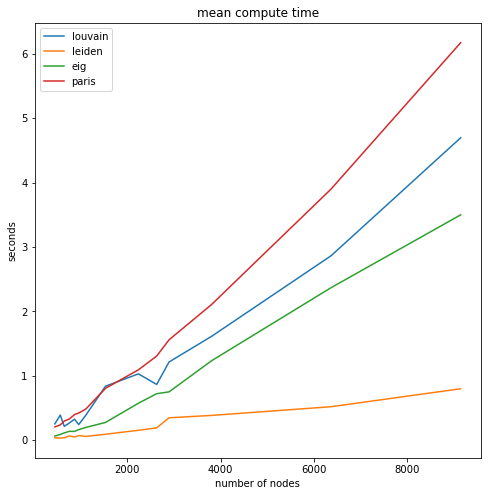

In [277]:
plt.figure(figsize=(8,8))
plt.title(f"mean compute time")

plt.xlabel('number of nodes')
plt.ylabel('seconds')
    
for ca in ['louvain' , 'leiden' , 'eig' , 'paris']:
    running_time_mean = []
    running_time_std = []
    nmi_mean = []
    nmi_std = []
    degree =[]
    for i,me in enumerate(metric):
        
        running_time_mean.append(np.mean([m[ca][1] for m in me]))

        nmi_mean.append(np.mean([m[ca][0] for m in me]))

        degree.append(np.mean([m for m in params[i]]))
        
   
        
    plt.plot(degree,running_time_mean , label=ca)
    

plt.legend(loc='best')
plt.savefig(f"compute time.png")
plt.show()


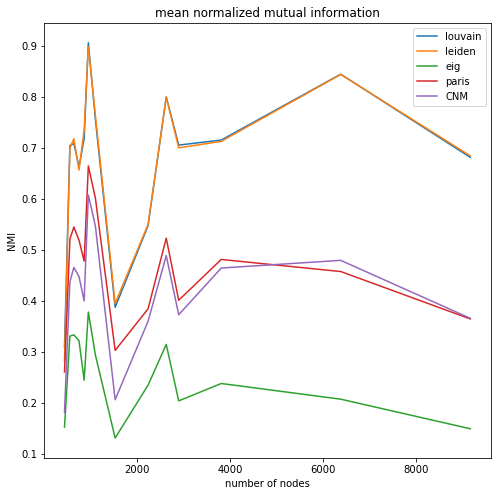

In [278]:
plt.figure(figsize=(8,8))
plt.title(f"mean normalized mutual information")

plt.xlabel('number of nodes')
plt.ylabel('NMI')
    
for ca in ['louvain' , 'leiden' , 'eig' , 'paris' , 'CNM']:
    running_time_mean = []
    running_time_std = []
    nmi_mean = []
    nmi_std = []
    degree =[]
    for i,me in enumerate(metric):
        
        running_time_mean.append(np.mean([m[ca][1] for m in me]))

        nmi_mean.append(np.mean([m[ca][0] for m in me]))

        degree.append(np.mean([m for m in params[i]]))
        
   
        
    plt.plot(degree,nmi_mean , label=ca)
    

plt.legend(loc='best')
plt.savefig(f"NMI.png")

plt.show()


In [269]:
for ca in com_algs: 
    l =[]
    ll = []
    for me in metric[:]:
        l+=[m[ca][1] for m in me]
        ll+=[m[ca][0] for m in me]
    print(f"{ca} mean running time : {np.mean(l)}")

    print(f"{ca} mean NMI : {np.mean(ll)}")


louvain mean running time : 1.0437565050205262
louvain mean NMI : 0.6896175168893928
leiden mean running time : 0.19110941085494867
leiden mean NMI : 0.6902989845112383
CNM mean running time : 31.68788979233814
CNM mean NMI : 0.4271437055470543
eig mean running time : 0.7074877214031059
eig mean NMI : 0.25945433921878863
paris mean running time : 1.3298959311316996
paris mean NMI : 0.4764379245344333


In [271]:
for ca in com_algs: 
    l =[]
    ll = []
    for me in metric[:3]:
        l+=[m[ca][1] for m in me]
        ll+=[m[ca][0] for m in me]
    print(f"{ca} mean running time : {np.mean(l)}")

    print(f"{ca} mean NMI : {np.mean(ll)}")


louvain mean running time : 0.2859632346941077
louvain mean NMI : 0.6377456270051977
leiden mean running time : 0.031443575154180115
leiden mean NMI : 0.6350523106163499
CNM mean running time : 1.0514171952786653
CNM mean NMI : 0.40512803896946875
eig mean running time : 0.09069367077039636
eig mean NMI : 0.30084782857658815
paris mean running time : 0.2530992445738419
paris mean NMI : 0.48622193206792136


In [173]:
import pickle 
# filehandler = open('../data/params.obj', 'wb') 
# pickle.dump(params, filehandler)


filehandler = open('../data/metrics3.obj', 'wb') 
pickle.dump(metric, filehandler)

filehandler = open('../data/graphs3.obj', 'wb') 
pickle.dump(graphs, filehandler)